# Simple Example of a Simulation in jf1uids

## Imports

In [9]:
# ==== GPU selection ====
from autocvd import autocvd
autocvd(num_gpus = 1)
# =======================

import jax.numpy as jnp

# constants
from jf1uids import SPHERICAL, CARTESIAN

# jf1uids option structures
from jf1uids import SimulationConfig
from jf1uids import SimulationParams

# simulation setup
from jf1uids import get_helper_data
from jf1uids import finalize_config
from jf1uids import get_registered_variables
from jf1uids import construct_state

# time integration, core function
from jf1uids import time_integration

# plotting
import matplotlib.pyplot as plt

## Simulation Setup

Let us set up a very simple simulation, mostly with default parameters.

First we get the configuration of the simulation, which contains parameters that typically do not change between simulations, changing which requires (just-in-time)-recompilation.

In [10]:
config = SimulationConfig(
    geometry = CARTESIAN,
    box_size = 1.0,
    num_cells = 101,
)

Next we setup the simulation parameters, things we might vary

In [11]:
params = SimulationParams(
    t_end = 0.2, # the typical value for a shock test
)

With this we generate some helper data, like the cell centers etc.

In [12]:
helper_data = get_helper_data(config)
registered_variables = get_registered_variables(config)

Next we setup the shock initial conditions, namely
\begin{equation}
\left(\begin{array}{l}
\rho \\
u \\
p
\end{array}\right)_L=\left(\begin{array}{l}
1 \\
0 \\
1
\end{array}\right), \quad\left(\begin{array}{l}
\rho \\
u \\
p
\end{array}\right)_R=\left(\begin{array}{c}
0.125 \\
0 \\
0.1
\end{array}\right)
\end{equation}
with seperation at $x=0.5$.

In [13]:
# setup the shock initial fluid state in terms of rho, u, p
shock_pos = 0.5
r = helper_data.geometric_centers
rho = jnp.where(r < shock_pos, 1.0, 0.125)
u = jnp.zeros_like(r)
p = jnp.where(r < shock_pos, 1.0, 0.1)

# get initial state
initial_state = construct_state(
    config = config,
    registered_variables = registered_variables,
    density = rho,
    velocity_x = u,
    gas_pressure = p,
)

In [14]:
config = finalize_config(config, initial_state.gas_state.shape)

Automatically setting open boundaries for Cartesian geometry.


## Running the simulation

In [15]:
final_state = time_integration(initial_state, config, params, registered_variables)
final_state = final_state.gas_state
rho_final = final_state[registered_variables.density_index]
u_final = final_state[registered_variables.velocity_index]
p_final = final_state[registered_variables.pressure_index]

## Visualization

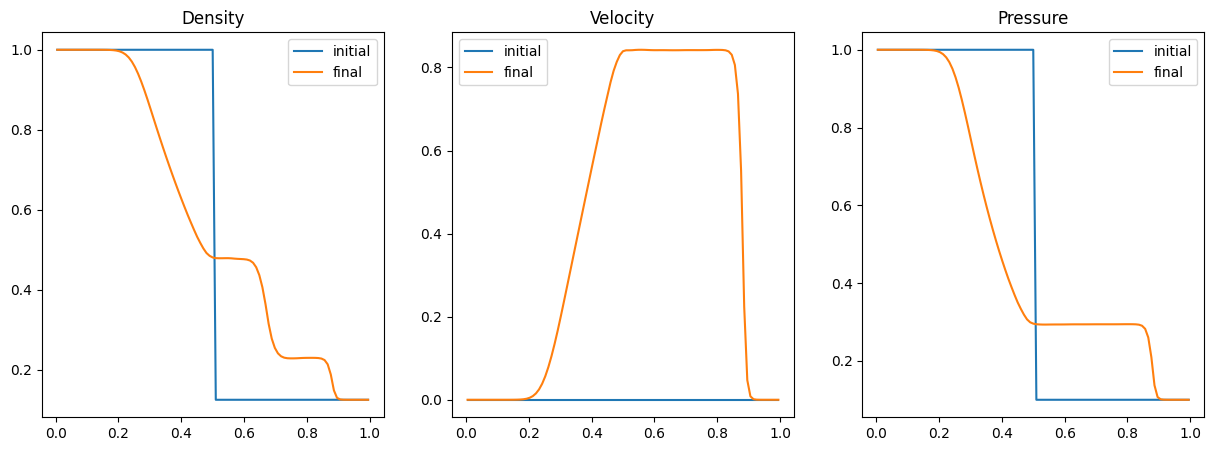

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].plot(r, rho, label='initial')
axs[0].plot(r, rho_final, label='final')
axs[0].set_title('Density')
axs[0].legend()

axs[1].plot(r, u, label='initial')
axs[1].plot(r, u_final, label='final')
axs[1].set_title('Velocity')
axs[1].legend()

axs[2].plot(r, p, label='initial')
axs[2].plot(r, p_final, label='final')
axs[2].set_title('Pressure')
axs[2].legend()